## Imports

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.9 MB/s eta 0:00:00


In [1]:
!pip uninstall gensim

Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gensim-4.3.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gensim/*
Proceed (Y/n)? Y
  Successfully uninstalled gensim-4.3.1


In [2]:
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gensim-3.8.3-cp39-cp39-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
karateclub 1.3.3 requires gensim>=4.0.0, but you have gensim 3.8.3 which is incompatible.


In [ ]:
!pip install karateclub

In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import networkx as nx
import ast

# for molecules
from rdkit import Chem
from rdkit.Chem import Draw
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from karateclub import Graph2Vec

## Data Cleaning and Exploration

### Load Dataset and quick description

In [5]:
df = pd.read_csv('molecule_training.csv')
df['toxicity'] = df['target'].apply(lambda x: 'toxic' if x == 1 else 'non-toxic')
df.head()

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,inchi_key,Graph,smiles,target,toxicity
0,2808,3.0,1.0,98.105,1.0,1.0,0.0,52.05,NCGC00258701-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,CC1=CC(N)=NO1,0,non-toxic
1,5043,3.0,1.0,115.176,1.0,0.0,2.0,32.59,NCGC00255097-01,[((0; 1); 1.0); ((1; 2); 1.0); ((1; 3); 1.0); ...,CC(C)CC(C)=NO,0,non-toxic
2,7354,3.0,1.0,268.229,4.0,3.0,2.0,133.75,NCGC00095787-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.0); ...,OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN...,0,non-toxic
3,4078,3.0,0.0,408.093,0.0,0.0,4.0,111.76,NCGC00185776-01,[((3; 4); 1.0); ((4; 5); 2.0); ((4; 6); 1.0); ...,O.[Na+].[Na+].[O-]C(=O)CC(S[Au])C([O-])=O,0,non-toxic
4,1631,3.0,1.0,147.004,0.0,1.0,0.0,0.00,NCGC00257953-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,ClC1=CC=C(Cl)C=C1,0,non-toxic


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7464 entries, 0 to 7463
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      7464 non-null   int64  
 1   Maximum Degree             7464 non-null   float64
 2   Minimum Degree             7464 non-null   float64
 3   Molecular Weight           7464 non-null   float64
 4   Number of H-Bond Donors    7464 non-null   float64
 5   Number of Rings            7464 non-null   float64
 6   Number of Rotatable Bonds  7464 non-null   float64
 7   Polar Surface Area         7464 non-null   float64
 8   inchi_key                  7464 non-null   object 
 9   Graph                      7464 non-null   object 
 10  smiles                     7464 non-null   object 
 11  target                     7464 non-null   int64  
 12  toxicity                   7464 non-null   object 
dtypes: float64(7), int64(2), object(4)
memory usage:

In [7]:
df.describe()

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,target
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000
mean,3731.500000,3.288183,0.875804,278.941072,1.252412,1.728162,4.208199,60.600695,0.040729
std,2154.815537,0.556245,0.390472,169.849479,2.012638,1.679037,4.525664,62.155964,0.197675
min,0.000000,0.000000,0.000000,41.053000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1865.750000,3.000000,1.000000,164.248000,0.000000,1.000000,1.000000,26.300000,0.000000
50%,3731.500000,3.000000,1.000000,240.444000,1.000000,1.000000,3.000000,46.530000,0.000000
75%,5597.250000,4.000000,1.000000,346.467000,2.000000,3.000000,6.000000,77.430000,0.000000
max,7463.000000,4.000000,2.000000,1950.681000,36.000000,30.000000,47.000000,1095.850000,1.000000


In [8]:
df.groupby('target')['index'].count().reset_index()

,target,index
0,0,7160
1,1,304


<Axes: xlabel='target', ylabel='count'>

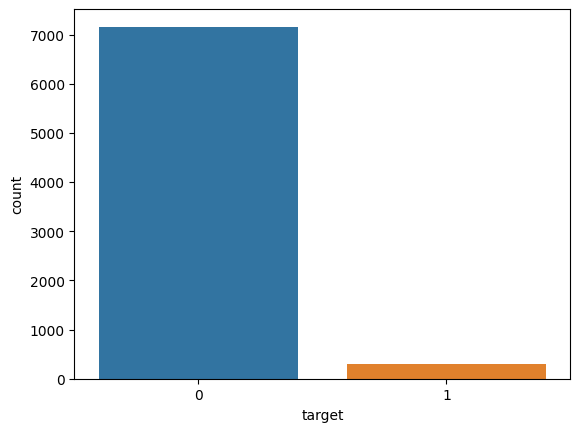

In [9]:
sns.countplot(x='target', data=df)

Remarque:  

**Bien faire attention quand on split les données entre train et test à garder cette répartition où il y'a bcp moins de molécules toxiques que non toxiques.**

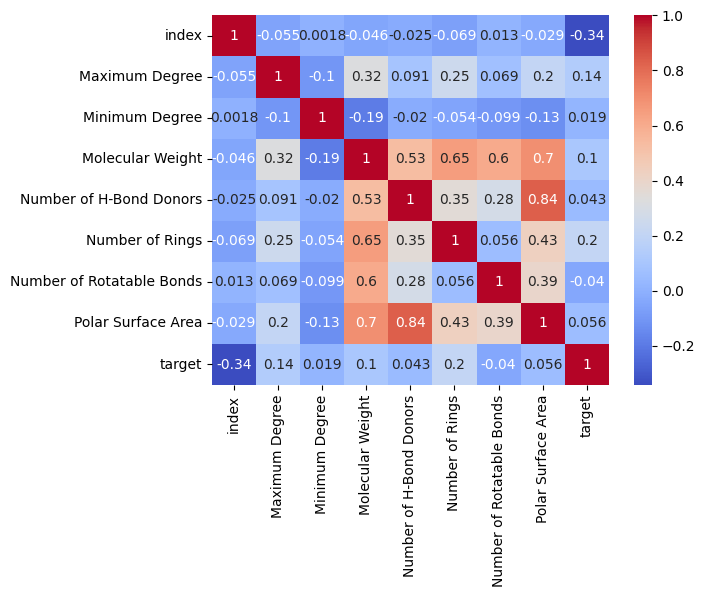

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

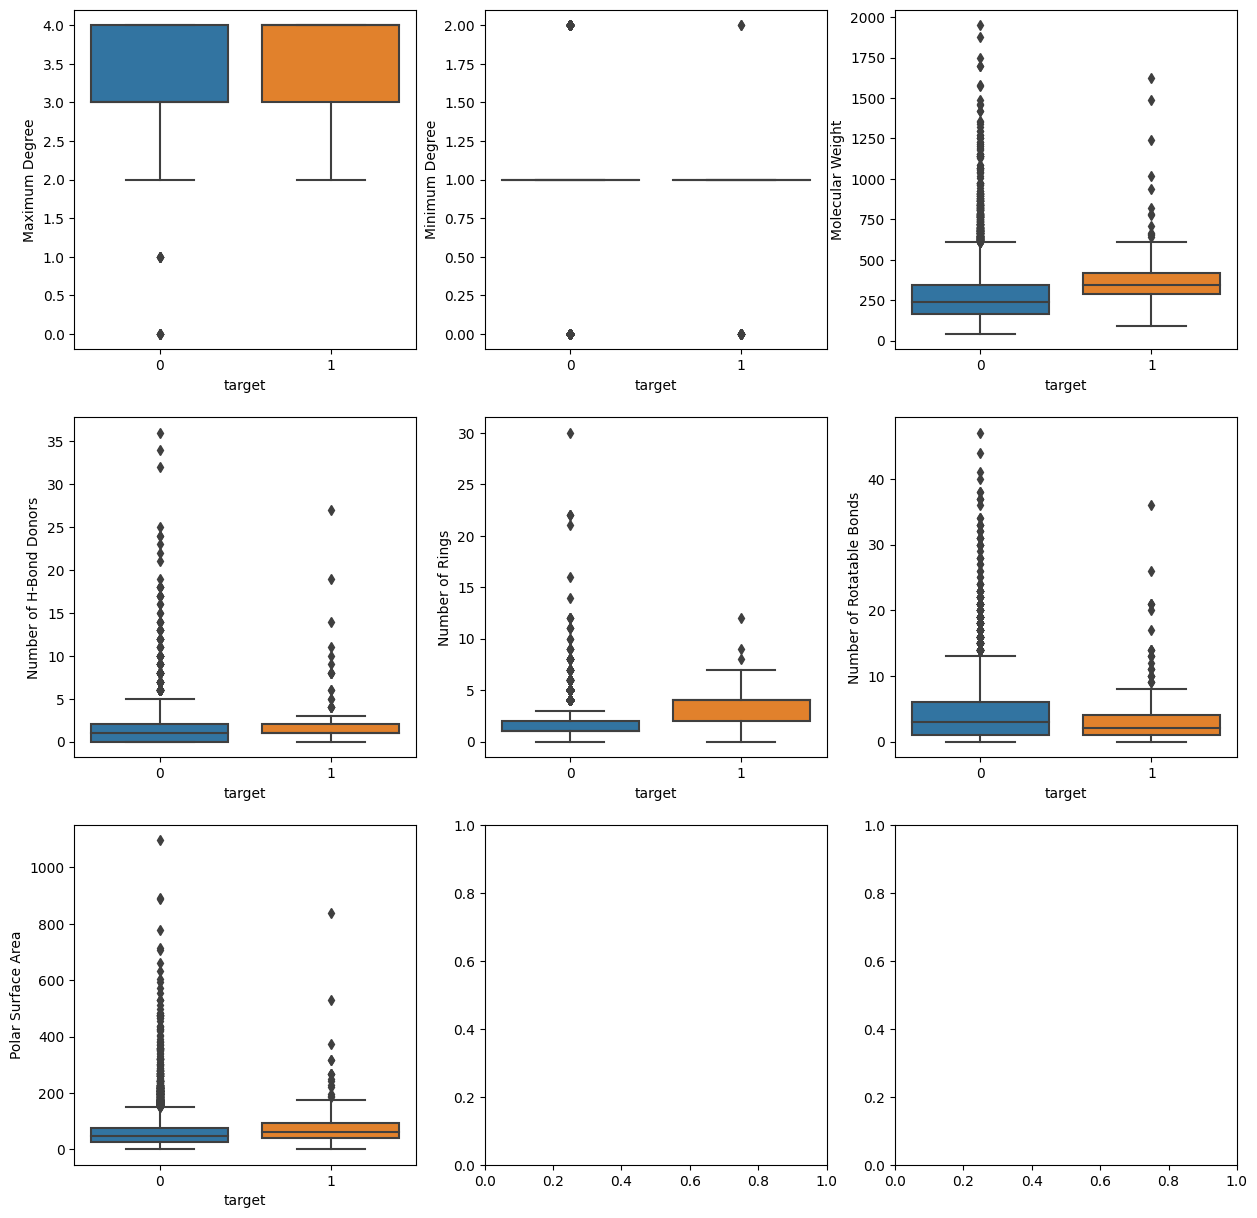

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

# Loop through the metrics and plot each one
for i, metric in enumerate(['Maximum Degree', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
                            'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']):
    row = i // 3
    col = i % 3
    
    sns.boxplot(x='target', y=metric, data=df, ax=axs[row, col])
  

plt.show()

### Transform graphs to networkx format

In [12]:
# Define a function to convert the graph string to a networkx graph object
def parse_graph(graph_string):
    # Parse the string as a list of tuples
    edges = ast.literal_eval(graph_string)
    # Create a new empty graph
    graph = nx.Graph()
    # Add edges to the graph
    for edge in edges:
        # Get the node labels and edge weight from the tuple
        node1, node2 = edge[0]
        weight = edge[1]
        # Add the edge to the graph
        graph.add_edge(node1, node2, weight=weight)
    return graph

In [13]:
# Convert the graph strings to networkx graph objects
df["Graph"] = df["Graph"].str.replace(";", ",")
df['graph_obj'] = df['Graph'].apply(parse_graph)

# use the molecules libraries
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

In [14]:
# Extract number of nodes and edges
df['num_nodes'] = df['graph_obj'].apply(lambda x: x.number_of_nodes())
df['num_edges'] = df['graph_obj'].apply(lambda x: x.number_of_edges())

In [15]:
df.head()

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,inchi_key,Graph,smiles,target,toxicity,graph_obj,mol,num_nodes,num_edges
0,2808,3.0,1.0,98.105,1.0,1.0,0.0,52.05,NCGC00258701-01,"[((0, 1), 1.0), ((1, 2), 1.5), ((2, 3), 1.5), ...",CC1=CC(N)=NO1,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6)",<rdkit.Chem.rdchem.Mol object at 0x7f900a021e40>,7,7
1,5043,3.0,1.0,115.176,1.0,0.0,2.0,32.59,NCGC00255097-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((1, 3), 1.0), ...",CC(C)CC(C)=NO,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7)",<rdkit.Chem.rdchem.Mol object at 0x7f900a021f20>,8,7
2,7354,3.0,1.0,268.229,4.0,3.0,2.0,133.75,NCGC00095787-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((2, 3), 1.0), ...",OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN...,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e46d0>,19,21
3,4078,3.0,0.0,408.093,0.0,0.0,4.0,111.76,NCGC00185776-01,"[((3, 4), 1.0), ((4, 5), 2.0), ((4, 6), 1.0), ...",O.[Na+].[Na+].[O-]C(=O)CC(S[Au])C([O-])=O,0,non-toxic,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12)",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e47b0>,10,9
4,1631,3.0,1.0,147.004,0.0,1.0,0.0,0.00,NCGC00257953-01,"[((0, 1), 1.0), ((1, 2), 1.5), ((2, 3), 1.5), ...",ClC1=CC=C(Cl)C=C1,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7)",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e4740>,8,8


### Split the datasets

In [16]:
# Create two sub-datasets: one for toxic molecules and one for non-toxic molecules
toxic_df = df[df['target'] == 1]
non_toxic_df = df[df['target'] == 0]

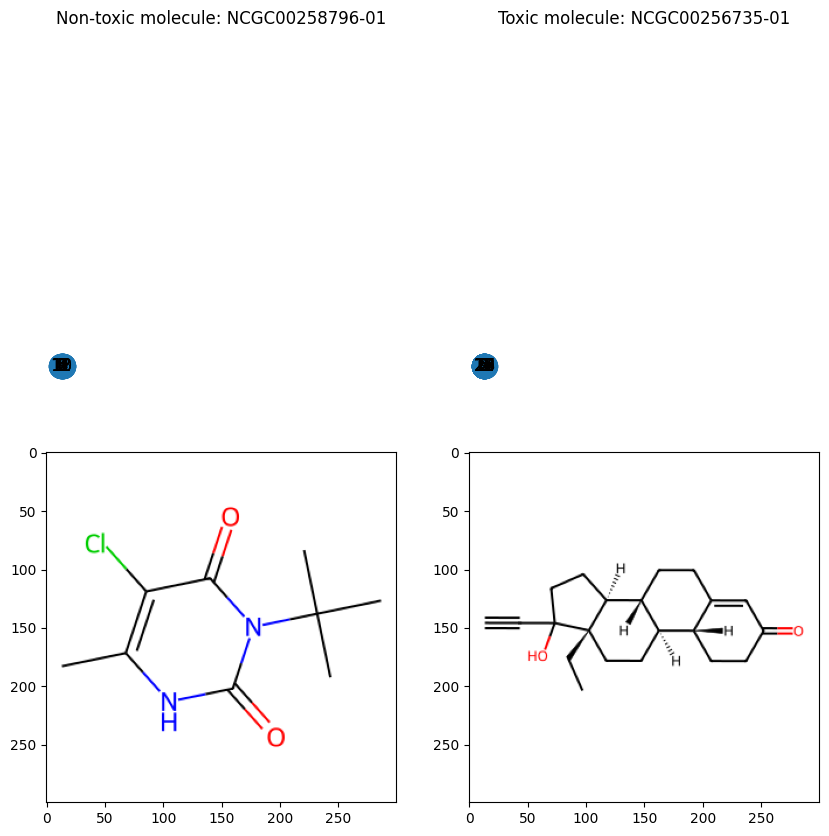

In [17]:
# Select a random non-toxic molecule and a random toxic molecule
non_toxic_mol = non_toxic_df.sample(1)
toxic_mol = toxic_df.sample(1)

# Get the graph objects of the selected molecules
non_toxic_graph = non_toxic_mol['graph_obj'].iloc[0]
toxic_graph = toxic_mol['graph_obj'].iloc[0]

img_non_toxic = non_toxic_mol['mol'].iloc[0]
img_toxic = toxic_mol['mol'].iloc[0]


# Create a figure with two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# Plot the non-toxic molecule
nx.draw_networkx(non_toxic_graph, ax=ax1)
ax1.set_title("Non-toxic molecule: {}".format(non_toxic_mol['inchi_key'].iloc[0]))
ax1.set_axis_off()

# Plot the toxic molecule
nx.draw_networkx(toxic_graph, ax=ax2)
ax2.set_title("Toxic molecule: {}".format(toxic_mol['inchi_key'].iloc[0]))
ax2.set_axis_off()

# Show non-toxic molecule
non_toxic_img = Draw.MolToImage(img_non_toxic)
ax3.imshow(non_toxic_img)

# Show toxic molecule
toxic_img = Draw.MolToImage(img_toxic)
ax4.imshow(toxic_img)

plt.show()


# Feature extraction

## Extract features

### Mol2vec features

In [18]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

In [19]:
w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

In [20]:
df["vec"] = sentences2vec(df['sentence'], w2v_model)

/usr/local/lib/python3.9/dist-packages/mol2vec/features.py:437: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(vec)


In [21]:
i=0
for x in sentences2vec(df['sentence'], w2v_model):
  if type(x)!=np.ndarray:
    print(i)
  i+=1

1629


In [22]:
df["vec"].iloc[1629]

0

In [23]:
df = df.drop(1629)

In [24]:
df.reset_index(inplace = True, drop=True)

In [25]:
df

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,inchi_key,Graph,smiles,target,toxicity,graph_obj,mol,num_nodes,num_edges,sentence,vec
0,2808,3.0,1.0,98.105,1.0,1.0,0.0,52.05,NCGC00258701-01,"[((0, 1), 1.0), ((1, 2), 1.5), ((2, 3), 1.5), ...",CC1=CC(N)=NO1,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6)",<rdkit.Chem.rdchem.Mol object at 0x7f900a021e40>,7,7,"(2246728737, 422715066, 3217380708, 3661262542...","[0.4328923, -1.1482646, -1.2955928, 2.8306396,..."
1,5043,3.0,1.0,115.176,1.0,0.0,2.0,32.59,NCGC00255097-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((1, 3), 1.0), ...",CC(C)CC(C)=NO,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7)",<rdkit.Chem.rdchem.Mol object at 0x7f900a021f20>,8,7,"(2246728737, 3537119515, 2245273601, 242354360...","[-0.6956083, 0.66568434, -0.5706683, -0.499615..."
2,7354,3.0,1.0,268.229,4.0,3.0,2.0,133.75,NCGC00095787-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((2, 3), 1.0), ...",OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN...,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e46d0>,19,21,"(864662311, 1535166686, 2245384272, 3153477100...","[5.8439264, -7.150183, -5.4017944, 5.3239045, ..."
3,4078,3.0,0.0,408.093,0.0,0.0,4.0,111.76,NCGC00185776-01,"[((3, 4), 1.0), ((4, 5), 2.0), ((4, 6), 1.0), ...",O.[Na+].[Na+].[O-]C(=O)CC(S[Au])C([O-])=O,0,non-toxic,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12)",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e47b0>,10,9,"(864666390, 3737048253, 3737048253, 864942795,...","[0.23464751, 0.25164545, -3.0528126, -1.383571..."
4,1631,3.0,1.0,147.004,0.0,1.0,0.0,0.00,NCGC00257953-01,"[((0, 1), 1.0), ((1, 2), 1.5), ((2, 3), 1.5), ...",ClC1=CC=C(Cl)C=C1,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7)",<rdkit.Chem.rdchem.Mol object at 0x7f900a1e4740>,8,8,"(1016841875, 3452535345, 3217380708, 224634082...","[0.2394084, -1.4815673, -0.711803, 3.6409636, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7458,4776,3.0,1.0,195.476,0.0,1.0,1.0,0.00,NCGC00256182-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((2, 3), 1.5), ...",ClCC1=CC=C(Cl)C=C1Cl,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",<rdkit.Chem.rdchem.Mol object at 0x7f8fff085270>,10,10,"(1016841875, 198706261, 2245384272, 3835033428...","[0.7906579, -1.8823903, -1.1502061, 3.6276774,..."
7459,3162,4.0,1.0,282.365,0.0,2.0,2.0,66.01,NCGC00260193-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((2, 3), 1.5), ...",CCN1C=C[N+](C)=C1.CC2=CC=C(C=C2)S([O-])(=O)=O,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",<rdkit.Chem.rdchem.Mol object at 0x7f8fff0852e0>,19,19,"(2246728737, 3542456614, 2245384272, 225184566...","[1.4802659, -2.369817, -1.899703, 5.4762363, 1..."
7460,2802,3.0,1.0,194.259,1.0,2.0,2.0,48.14,NCGC00258195-01,"[((0, 1), 1.0), ((1, 2), 1.0), ((2, 3), 1.0), ...",CCOC1=CC=C2N=C(N)SC2=C1,0,non-toxic,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)",<rdkit.Chem.rdchem.Mol object at 0x7f8fff085350>,13,14,"(2246728737, 3542456614, 2245384272, 399408866...","[0.40441626, -0.5685223, -1.5168611, 4.393994,..."
7461,1820,3.0,1.0,173.393,1.0,0.0,1.0,37.30,NCGC00258448-01,"[((0, 1), 1.0), ((1, 2), 2.0), ((1, 3), 1.0), ...",OC(=O)C(Cl)Br,0,non-toxic,"(0, 1, 2, 3, 4, 5)",<rdkit.Chem.rdchem.Mol object at 0x7f8fff0853c0>,6,5,"(864662311, 1533864325, 2246699815, 3855312692...","[0.07461004, 0.7110093, -1.419729, -0.6211774,..."


In [26]:
df['embedding'] = [DfVec(x) for x in df["vec"]]

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)


df_mol2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.432892,-1.148265,-1.295593,2.830640,1.501820,0.395403,-2.729602,-1.660501,1.254106,-1.217803,...,-0.100305,1.867382,3.234128,-1.098881,-2.462197,-1.142829,-2.302124,-0.135109,-2.861818,-0.552656
1,-0.695608,0.665684,-0.570668,-0.499616,3.588313,-0.173725,-2.371433,-0.942077,3.326228,-1.887655,...,-0.149212,1.695873,3.216152,0.603311,-1.743970,-0.981935,-1.515858,-1.247859,-4.260800,-1.085652
2,5.843926,-7.150183,-5.401794,5.323905,-0.346161,-1.742886,-7.615536,-1.616421,-1.934688,1.058362,...,-4.199099,8.673381,5.756387,-1.673199,-6.537354,-7.571887,-5.923907,-4.011438,-11.431290,0.976179
3,0.234648,0.251645,-3.052813,-1.383571,3.002864,-0.269477,-3.548233,0.150195,1.836320,2.348825,...,0.671994,4.270946,1.536611,2.394891,0.838491,-0.534440,0.500261,-1.763674,-4.088911,0.781893
4,0.239408,-1.481567,-0.711803,3.640964,-1.091899,1.142029,-2.324828,0.227074,3.509125,2.812115,...,-2.277948,3.842560,4.980514,-0.003749,-1.949442,-0.427221,-1.615954,0.038887,-2.373425,-1.228086


### Graph2Vec embedding

In [31]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

In [32]:
df['graph_2'] = df['mol'].apply(lambda x: mol_to_nx(x))

In [37]:
model = Graph2Vec()
model.fit(df['graph_2'])
df_graph2vec = model.get_embedding()

df_graph2vec = pd.DataFrame(df_graph2vec)
df_graph2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.055828,-0.027866,-0.017317,-0.009195,-0.011306,-0.014839,-0.070504,-0.004827,-0.015614,0.027011,...,0.004368,-0.030921,-0.002713,0.027934,0.016523,0.040433,0.037941,-0.037017,0.008340,0.015354
1,0.071110,-0.034056,-0.013723,-0.010046,-0.013513,-0.009006,-0.078818,-0.009502,-0.025180,0.034692,...,0.008606,-0.031370,0.003073,0.039330,0.021458,0.047908,0.043664,-0.047034,0.010940,0.019605
2,0.075331,-0.033149,-0.016978,-0.012424,-0.010708,-0.017014,-0.083899,-0.007681,-0.025578,0.029354,...,0.008686,-0.035181,-0.004233,0.033988,0.015835,0.049507,0.042087,-0.049995,0.009194,0.016498
3,0.068328,-0.028824,-0.018585,-0.014293,-0.008118,-0.015212,-0.082061,-0.011832,-0.024936,0.032149,...,0.009861,-0.032068,0.003586,0.037435,0.018100,0.048727,0.046725,-0.050003,0.014463,0.014532
4,0.052461,-0.021910,-0.008860,-0.003778,-0.007121,-0.009620,-0.055596,-0.009465,-0.018022,0.019965,...,0.005300,-0.026033,-0.001729,0.027526,0.012408,0.030650,0.028846,-0.032358,0.009453,0.012930
